In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs

# Set wide fig size for plots
plt.rcParams['figure.figsize']=(12,3)



In [2]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax



In [3]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])



In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics



In [5]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig



In [6]:
# Load in stock data
ts = pd.read_csv("WMT.csv", 
                  parse_dates=['Date'], index_col='Date')
ts.head()

,Adj Close
Date,
2000-01-03,44.915394
2000-01-04,43.234756
2000-01-05,42.352402
2000-01-06,42.814564
2000-01-07,46.049828


In [7]:
# Check the data type of the index
print(ts.index.dtype)

datetime64[ns]


In [8]:
# Filter for 2010-2020 and only the adj close value
ts = ts.loc['2010':'2020', 'Adj Close']

In [9]:
# Preview the index
ts.index

DatetimeIndex(['2010-01-01', '2010-01-04', '2010-01-05', '2010-01-06',
               '2010-01-07', '2010-01-08', '2010-01-11', '2010-01-12',
               '2010-01-13', '2010-01-14',
               ...
               '2020-12-18', '2020-12-21', '2020-12-22', '2020-12-23',
               '2020-12-24', '2020-12-25', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=2870, freq=None)

In [10]:
# Resample for business day with 'B'
ts = ts.resample('B').asfreq()
ts

Date
2010-01-01           NaN
2010-01-04     40.963638
2010-01-05     40.555729
2010-01-06     40.465084
2010-01-07     40.487759
                 ...    
2020-12-25           NaN
2020-12-28    142.946777
2020-12-29    142.041183
2020-12-30    141.923065
2020-12-31    141.893524
Freq: B, Name: Adj Close, Length: 2870, dtype: float64

In [11]:
ts.isna().sum()

101

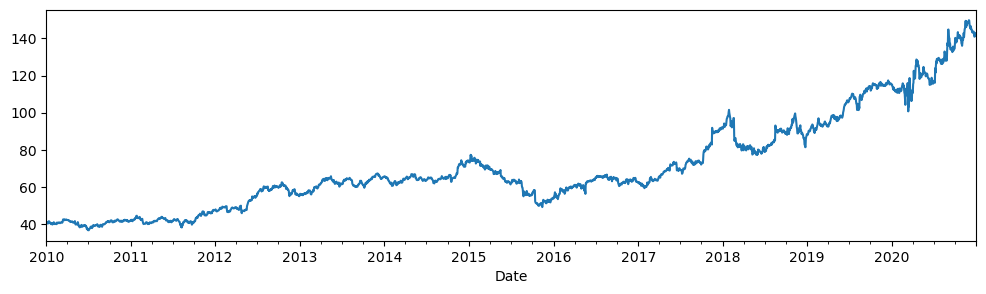

In [12]:
# Fill missing values with previous value
ts = ts.fillna(method='ffill')
ts.plot();

In [18]:
ts.isna().sum()

1

In [21]:
ts = ts.fillna(method='bfill')

In [22]:
ts.isna().sum()

0

In [23]:
# Inspect null values
null = ts.isna()
ts[null].head(20)

Series([], Freq: B, Name: Adj Close, dtype: float64)

In [24]:
# Testing the raw data for stationarity
get_adfuller_results(ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,1.457375,23,2846,0.99736,0.05,False


,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-12.211384,22,2846,0.0,0.05,True


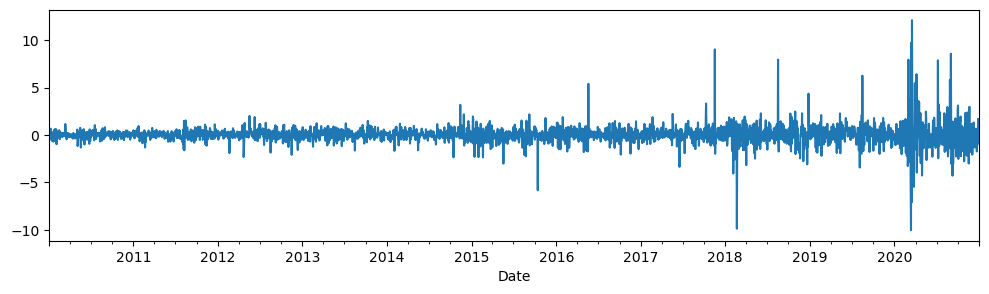

In [25]:
# Differencing the data once
ts_diff = ts.diff().dropna()
ts_diff.plot()
# Checking for stationarity
get_adfuller_results(ts_diff)


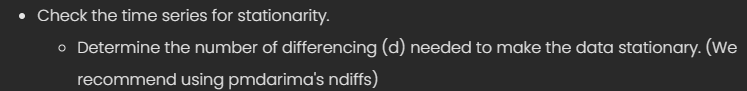

# Using pmdarima's ndiffs to determine the number of differencings required

In [26]:
# use ndiffs to determine differencing
d = ndiffs(ts)
print(f'd is {d}')

d is 1


In [27]:
# Example below is only differencing once which is what the pmdarmias determined in last cell d=1
# so you will only see .diff() once
# example if you had d=2 which have two .diff() exp: ts_diff2 =ts.diff().diff().dropna()
ts_diff1 = ts.diff().dropna()

# 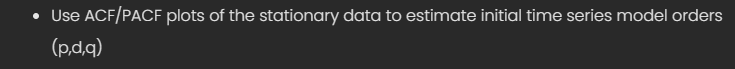

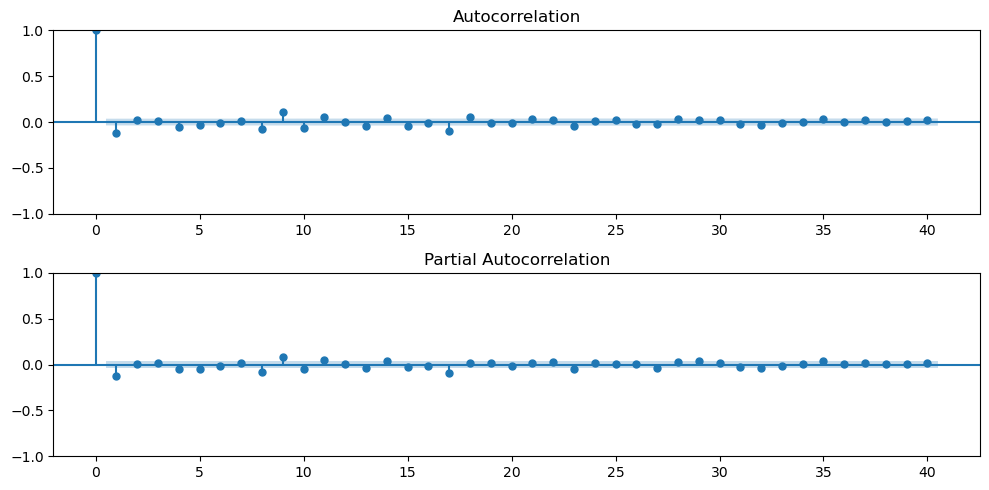

In [28]:
plot_acf_pacf(ts_diff1);

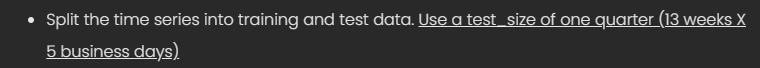

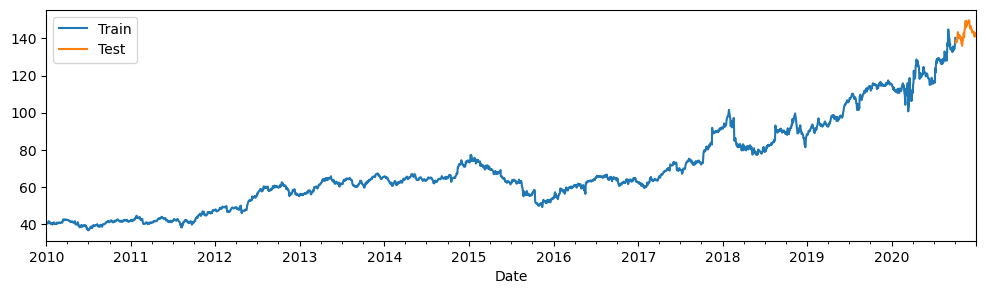

In [29]:
# Calculating number of test lags
n_test_lags = 5*13

# Modeling to predict 6 months into the future
train, test = train_test_split(ts, test_size=n_test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();


# 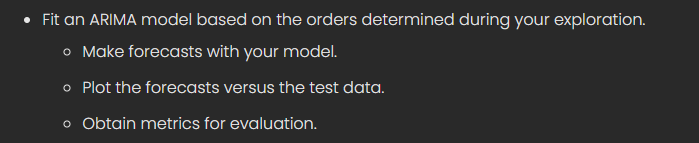

In [30]:
# Build the model 
p = 0  # AR component 

d = 1  # Number of differencing required to make stationary

q =  1 # MA component 

# Define and fit the model
arima_model = tsa.ARIMA(train, order=(p,d,q)).fit()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 3.813
- MSE = 22.964
- RMSE = 4.792
- R^2 = -0.786
- MAPE = 2.62%


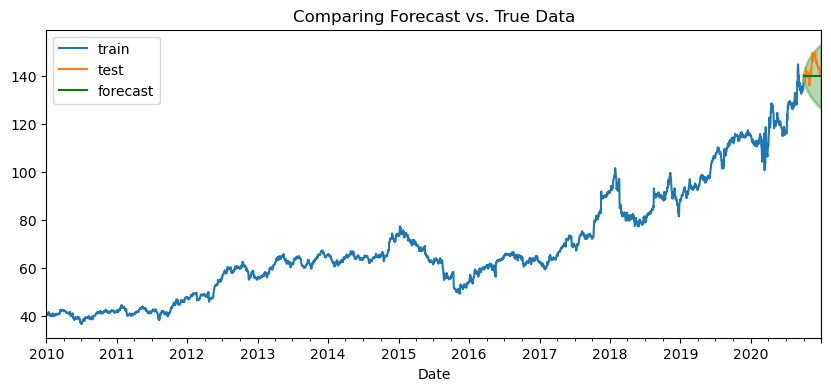

In [31]:
# Obtain summary of forecast as dataframe
forecast_df = arima_model.get_forecast(len(test)).summary_frame()

# Plot the forecast with true values
plot_forecast(train, test, forecast_df)

# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])


# 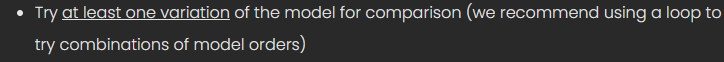

In [32]:
# Obtain summary of model
arima_model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2805
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3889.130
Date:                Sun, 14 Jan 2024   AIC                           7782.259
Time:                        20:21:43   BIC                           7794.137
Sample:                    01-01-2010   HQIC                          7786.547
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1161      0.006    -19.197      0.000      -0.128      -0.104
sigma2         0.9381      0.006    148.421      0.000       0.926       0.950
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):            116415.03
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):              10.49   Skew:                             0.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

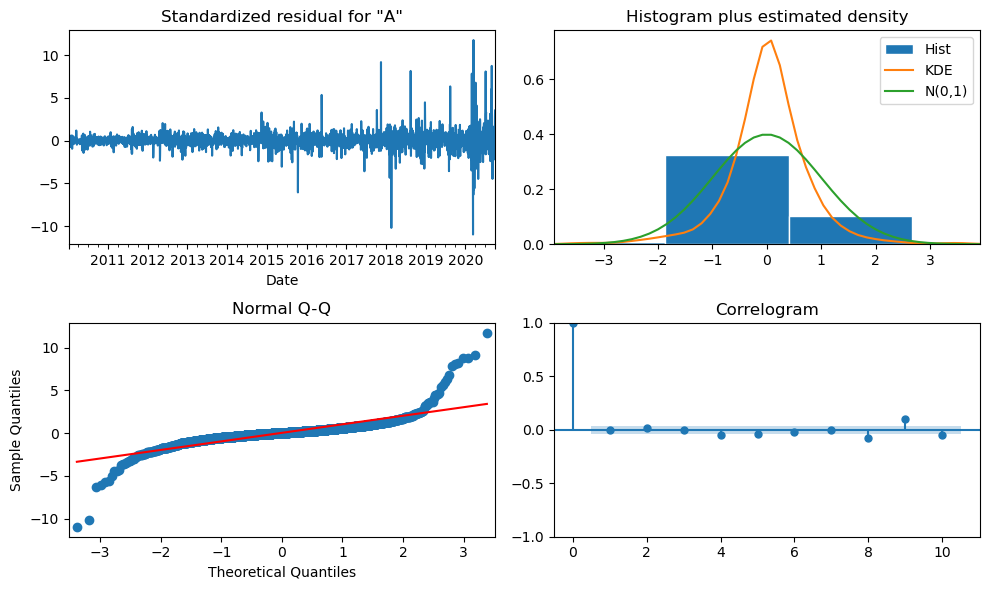

In [33]:
# Obtain diagnostic plots
fig = arima_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()



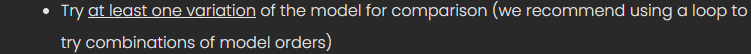

In [34]:
import itertools

# Define the value or range of values for p, d, q
p_values = range(0, 4)  
d_values = [2]          
q_values = range(0, 4)  

# Create combinations of pdq to test
pdq_to_try = list(itertools.product(p_values, d_values, q_values))
                                            
pdq_to_try



[(0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (3, 2, 0),
 (3, 2, 1),
 (3, 2, 2),
 (3, 2, 3)]

In [35]:
# We now want to fit a model and obtain a metric for comparison. Here, we will use AIC.
# A lower AIC score is better. We will start by defining the "best_aic" variable as infinity 
# and then update it whenever it improves.
# define starting aic as infinity
best_aic = float("inf")  

# define baseline for pdq
best_pdq = (0,0,0)

# Loop through each combination
for pdq in pdq_to_try:
    
    model = tsa.ARIMA(train, order=pdq)
                              
    result = model.fit()
    
    print(pdq, result.aic)      
    
    # If lower, replace best AIC with new value
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdq = pdq

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdq:", best_pdq)



(0, 2, 0) 10070.877815796566
(0, 2, 1) 7823.537117870431
(0, 2, 2) 7785.476471759983
(0, 2, 3) 7786.365538005793
(1, 2, 0) 8999.800284419038
(1, 2, 1) 7784.4214548004675
(1, 2, 2) 7786.306063351647


C:\Users\rdrlr\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\rdrlr\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 2, 3) 7786.177212957508
(2, 2, 0) 8621.399548631001
(2, 2, 1) 7786.299653348794


C:\Users\rdrlr\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\rdrlr\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 2, 2) 7782.98097981056


C:\Users\rdrlr\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 2, 3) 7791.946424745867
(3, 2, 0) 8472.562231134045
(3, 2, 1) 7788.296639133609


C:\Users\rdrlr\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\rdrlr\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 2, 2) 7782.189694542599
(3, 2, 3) 7756.694006727795
Best AIC: 7756.694006727795
Best pdq: (3, 2, 3)


C:\Users\rdrlr\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [38]:
# Build the model with the best AIC
p = 3  # AR component 

d = 2  # Number of differencing required to make stationary

q = 3 # MA component 

# Define and fit the model
ar_2_ma_3_model = tsa.ARIMA(train, order=(p,d,q)).fit()



C:\Users\rdrlr\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


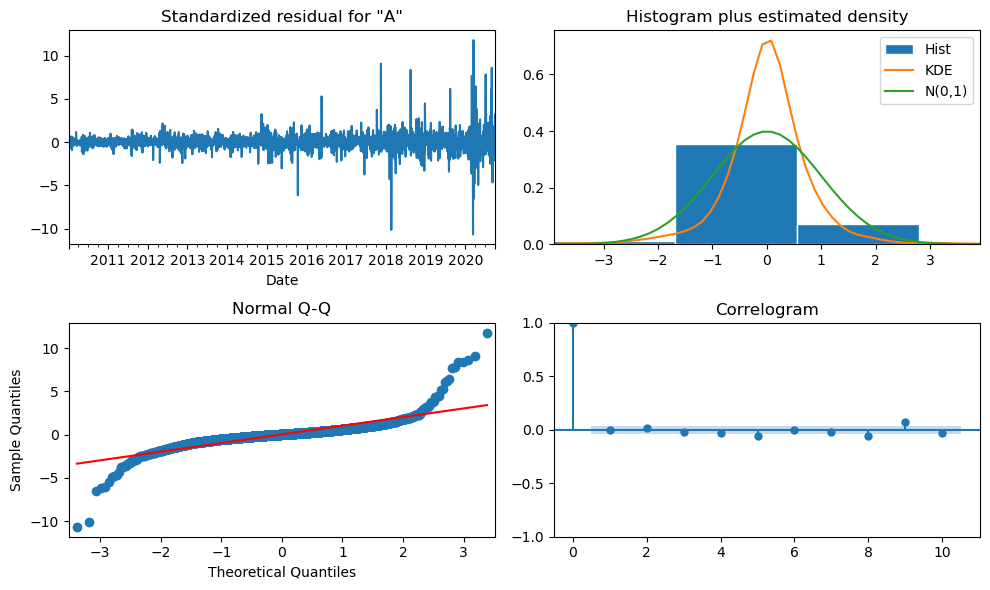

In [39]:
# Obtain diagnostic plots
fig = ar_2_ma_3_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 2.981
- MSE = 15.621
- RMSE = 3.952
- R^2 = -0.215
- MAPE = 2.05%


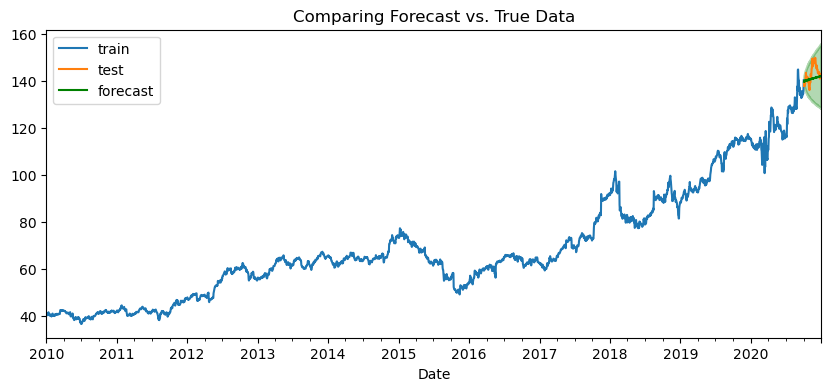

In [40]:
#Next, compare the metrics.
# Obtain summary of forecast as dataframe
forecast_df = ar_2_ma_3_model.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

